In [46]:
import os
import sys
import numpy as np
import pandas as pd
#import pickle
import dill as pickle # https://stackoverflow.com/questions/25348532/can-python-pickle-lambda-functions
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pyperclip
import joblib
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from utils import pre_process_df
from custom_transformers.transformers import PreProcessingTransformer, DropColumnsTransformer, CustomImputer, variables_mapping

In [45]:
df = pd.read_csv(os.path.join("data", "train_data.csv"))

In [3]:
duplicated_patients = pd.read_csv(os.path.join("data", "duplicated_patients.csv")).patient_id

## Balance Data

In [4]:
# Convert the target variable into a boolean
df['readmitted'] = df['readmitted'] == 'Yes'

In [5]:
# Remove patients with corrupted data, without readmissions
to_remove = (df.readmitted == False) & (df.patient_id.isin(duplicated_patients))
df = df[~to_remove]

In [6]:
df.shape

(54214, 34)

In [7]:
df.readmitted.sum()

9072

In [8]:
# Balance data further by undersampling the non-readmitted
remove_n = 54214 - 9072 - 9072

np.random.seed(42)
drop_indices = np.random.choice(df[df.readmitted == False].index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

In [9]:
df_subset.readmitted.sum()

9072

In [10]:
df_subset.shape

(18144, 34)

In [11]:
df = df_subset

## train/test split

In [12]:
ordered_columns = ['admission_id', 'patient_id', 'race', 'gender', 'age', 'weight',
       'admission_type_code', 'discharge_disposition_code',
       'admission_source_code', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'has_prosthesis', 'complete_vaccination_status',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'blood_type',
       'hemoglobin_level', 'blood_transfusion', 'max_glu_serum', 'A1Cresult',
       'diuretics', 'insulin', 'change', 'diabetesMed']

In [13]:
def create_target(df):
    X = df[ordered_columns]
    y = df['readmitted']
    #.apply(lambda value: known_categories['readmitted']['mapping'](value)).astype(known_categories['readmitted']['type'])
    
    return X, y

In [14]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['readmitted'], random_state=42)

X_train, y_train = create_target(df_train)
X_test, y_test = create_target(df_test)

In [15]:
df_test.shape

(3629, 34)

In [16]:
df_test.readmitted.sum()

1814

In [17]:
#for numeric_column in X_train.select_dtypes(include=["int64"]).columns:
#    X_train[numeric_column] = X_train[numeric_column].astype("Int64")

In [18]:
#with open('dtypes.pickle', 'wb') as fh:
#    pickle.dump(X_train.dtypes, fh)

## Modelling

In [19]:
preprocess_pieline = make_pipeline(
    PreProcessingTransformer(),
    DropColumnsTransformer(),
    CustomImputer()    
)

In [20]:
preprocess_pieline.fit(X_train, y_train)

Pipeline(steps=[('preprocessingtransformer',
                 <custom_transformers.transformers.PreProcessingTransformer object at 0x129d99990>),
                ('dropcolumnstransformer',
                 <custom_transformers.transformers.DropColumnsTransformer object at 0x129d80990>),
                ('customimputer',
                 <custom_transformers.transformers.CustomImputer object at 0x129d80050>)])

In [21]:
df.dtypes

admission_id                     int64
patient_id                       int64
race                            object
gender                          object
age                             object
weight                          object
admission_type_code            float64
discharge_disposition_code     float64
admission_source_code            int64
time_in_hospital                 int64
payer_code                      object
medical_specialty               object
has_prosthesis                    bool
complete_vaccination_status     object
num_lab_procedures             float64
num_procedures                   int64
num_medications                float64
number_outpatient                int64
number_emergency                 int64
number_inpatient                 int64
diag_1                          object
diag_2                          object
diag_3                          object
number_diagnoses                 int64
blood_type                      object
hemoglobin_level         

In [22]:
#Logistic regression - LogisticRegression
#Stochastic gradient descent
#Random forest
#Gradient boosting classifier
categorical_features = [
    'admission_type_code',
    'discharge_disposition_code',
    'admission_source_code',
    'payer_code',
    'complete_vaccination_status',
    'diag_1',
    'diag_2',
    'diag_3',
    'blood_type'
]

numerical_features = [
    'time_in_hospital',
    'has_prosthesis',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient',
    'number_diagnoses',
    'hemoglobin_level',
    'blood_transfusion',
    'A1Cresult',
    'diuretics',
    'change',
    'diabetesMed'
]

pipeline = make_pipeline(
    PreProcessingTransformer(),
    DropColumnsTransformer(),
    CustomImputer(),  
    #OneHotEncoder(handle_unknown='ignore'),
    ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
    ),
    #LogisticRegression(random_state=42)
    #RandomForestClassifier(random_state=42, max_depth=3, n_estimators=25)
    #SGDClassifier(random_state=42, loss = 'log')
    GradientBoostingClassifier(random_state=42, n_estimators=15, learning_rate=1.0, max_depth=3)
    #LogisticRegression(random_state=42)
)

In [23]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessingtransformer',
                 <custom_transformers.transformers.PreProcessingTransformer object at 0x129d61cd0>),
                ('dropcolumnstransformer',
                 <custom_transformers.transformers.DropColumnsTransformer object at 0x129d99fd0>),
                ('customimputer',
                 <custom_transformers.transformers.CustomImputer object at 0x129d99bd0>),
                ('columntransformer',
                 ColumnTransform...
                                                   'A1Cresult', 'diuretics',
                                                   'change', 'diabetesMed']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['admission_type_code',
                                                   'discharge_disposition_code',
                                                   'admis

In [24]:
#joblib.dump(pipeline, 'pipeline.pickle') 

In [25]:
#categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat']
#random_forest_step = pipeline.named_steps['gradientboostingclassifier']
#random_forest_step = pipeline.named_steps['randomforestclassifier']

#onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_features)

#importances = pd.Series(data=random_forest_step.feature_importances_, index = np.array(numerical_features + list(onehot_columns)))

#indices = np.argsort(importances)[::-1]
#print("Feature ranking:")

#for f in range(X_train.shape[1]):
#    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

#std = np.std([tree.feature_importances_ for tree in random_forest_step.estimators_], axis=0)

#plt.figure()
#plt.title("Feature importances")

#MAX_FEAT = 15
#plt.bar(x=importances.index[indices][:MAX_FEAT], height=importances[indices][:MAX_FEAT],
#        color="r", yerr=std[indices][:MAX_FEAT], align="center");
#plt.xticks(range(len(importances.index[indices][:MAX_FEAT])), importances.index[indices][:MAX_FEAT], rotation=45, ha="right")
##plt.xlim([-1, X_train.shape[1]])
##plt.xlabel('Features');
#plt.ylabel('Importance');

#plt.gcf().set_size_inches(12,4)
#plt.gcf().savefig("images/feature_importance.pdf")

#plt.show()


Feature ranking:
1. feature number_inpatient (0.683061)
2. feature discharge_disposition_code_Discharged to home (0.064717)
3. feature discharge_disposition_code_Expired (0.044632)
4. feature number_diagnoses (0.020935)
5. feature discharge_disposition_code_Discharged/transferred to another rehab fac including rehab units of a hospital (0.019504)
6. feature num_medications (0.017035)
7. feature number_emergency (0.009563)
8. feature num_lab_procedures (0.007730)
9. feature num_procedures (0.007660)
10. feature discharge_disposition_code_Discharged/transferred to SNF (0.006006)
11. feature number_outpatient (0.005698)
12. feature diabetesMed (0.005698)
13. feature diag_1_diseases of the musculoskeletal system and connective tissue (0.005639)
14. feature discharge_disposition_code_Discharged/transferred to home with home health service (0.005511)
15. feature discharge_disposition_code_Discharged/transferred to another type of inpatient care institution (0.005430)
16. feature payer_code_M

AttributeError: 'numpy.ndarray' object has no attribute 'feature_importances_'

## Analysing the dataset

In [26]:
def find_best_threshold(preds_proba, y_test, min_recall=0.5, min_precision=0.65):

    threshold = 0.5
    threshold_recall = 0
    threshold_precision = 0

    best_f1score = 0

    for i in range(100):
        current_threshold = i / 100

        best_preds = preds_proba > current_threshold
        
        precision = precision_score(y_test, best_preds) #, pos_label=True)
        recall = recall_score(y_test, best_preds)
        
        f1score = f1_score(y_test, best_preds)
        accuracy = accuracy_score(y_true=y_test, y_pred=best_preds)
        
        if recall >= min_recall and precision >= min_precision and recall > threshold_recall:
            threshold = current_threshold
            threshold_recall = recall
            threshold_precision = precision
            threshold_accuracy = accuracy
        
        if f1score > best_f1score:
            best_f1score = f1score
            
    return threshold, threshold_precision, threshold_recall, best_f1score, threshold_accuracy

In [27]:
y_pred_train = pipeline.predict_proba(X_train)[:,1]
y_pred_test = pipeline.predict_proba(X_test)[:,1]

In [28]:
# Find best threshold

threshold_train, precision_train, recall_train, f1_train, accuracy_train = find_best_threshold(y_pred_train, y_train)
threshold_test, precision_test, recall_test, f1_test, accuracy_test = find_best_threshold(y_pred_test, y_test)

In [29]:
(threshold_train, precision_train, recall_train, f1_train, accuracy_train)

(0.37,
 0.6544683699654134,
 0.8082116285478094,
 0.7233630141135138,
 0.6907337237340682)

In [30]:
(threshold_test, precision_test, recall_test, f1_test, accuracy_test)

(0.38,
 0.6501364877161055,
 0.7877618522601985,
 0.7124939700916546,
 0.6820060622761092)

In [36]:
def get_descrimination_dict(df_, sensitive_columns=['age', 'race', 'gender', 'is_insured', 'medical_specialty'], target='readmitted'):
    """ 
    """
    
    specialties = df_['medical_specialty'].unique()
        
    result = {}
    for sensitive_column in sensitive_columns:
        classes = sorted([ str(x) for x in df_[sensitive_column].unique() ])        
        
        result[sensitive_column] = {}
        #result[sensitive_column]['classes_order'] = classes # Preserve the order we iterate through sensitive class
        to_remove = ['Anesthesiology', 'Endocrinology', 'Gynecology/Obstetrics', 'Neurology', 'Ophthalmology', 'InfectiousDiseases', 'Podiatry', 'unknown']
        
        for class_ in classes:
            if class_ not in to_remove:
                medical_encounters = df_[(df_[sensitive_column] == class_)]

                y_true = medical_encounters.readmitted.astype(bool)
                y_pred = medical_encounters.prediction.astype(bool)

                precision = precision_score(y_true, y_pred, labels=[True])

                result[sensitive_column][class_] = precision
    
    return result
        
# print(json.dumps(verify_descrimination(df)))

In [47]:
df_ = pre_process_df(X_test)
df_['prediction'] = y_pred_test >= 0.61
df_['readmitted'] = y_test


df_['is_insured'] = df_.payer_code.fillna('BC').apply(lambda x: 'insured' if np.nan_to_num(x) == 'SP' else 'not insured').astype('category')
df_['age'] = df_.age.apply(lambda x: str(x)).astype('category')

dict_ = get_descrimination_dict(df_)

/Users/rafael.gil/.virtualenvs/capstone/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
def plot_dict(D, name):
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))

    plt.ylabel("Precision - Readmission Rate")
    #plt.gcf().set_size_inches(6,4)
    plt.gcf().set_size_inches(12,4)
    plt.xticks(rotation=90)
    
    plt.gcf().savefig("images/week0/discrimination_requirement_" + sensitive_column + ".pdf")

    plt.show()

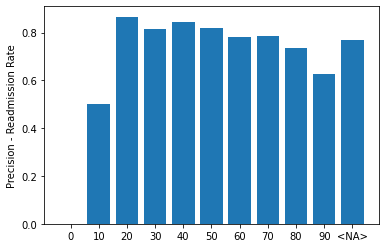

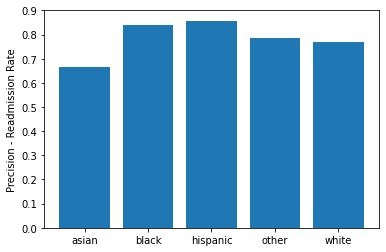

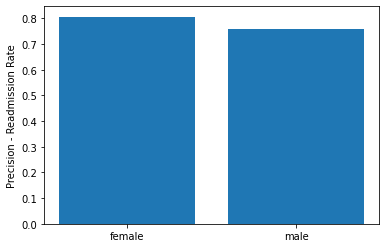

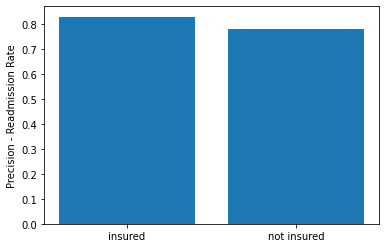

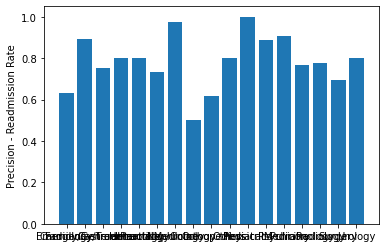

In [51]:
for sensitive_column in ['age', 'race', 'gender', 'is_insured', 'medical_specialty']:
    plot_dict(dict_[sensitive_column], sensitive_column)

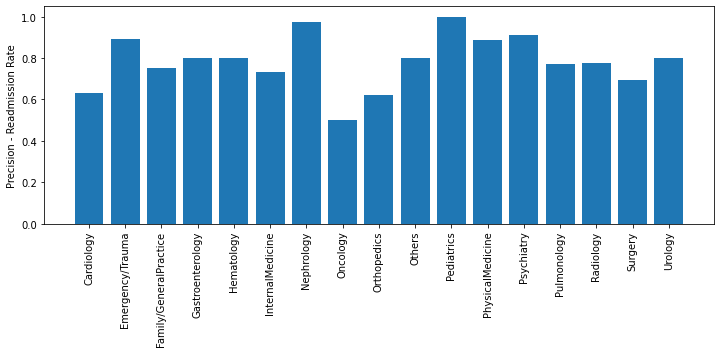

In [53]:
plot_dict(dict_['medical_specialty'], 'medical_specialty')

In [56]:
for sensitive_column in ['age', 'race', 'gender', 'is_insured', 'medical_specialty']:
    values = dict_[sensitive_column].values()
    values = [ x for x in values if x != 0 and x != 1]
    
    min_ = min(values)
    max_ = max(values)
    print(sensitive_column + ' - ' + str(max_-min_))

age - 0.3666666666666667
race - 0.19047619047619047
gender - 0.04862579281183932
is_insured - 0.04737160349193148
medical_specialty - 0.472972972972973


In [ ]:
def plot_precision_recall_evolution():
    precision = []
    recall = []
    accuracy = []
    
    thresholds = []
    lim = []


    for i in range(100):
        current_threshold = i / 100

        thresholds.append(current_threshold)
        best_preds = y_pred_test > current_threshold

        precision.append(precision_score(y_true=y_test, y_pred=best_preds, pos_label=True))
        recall.append(recall_score(y_true=y_test, y_pred=best_preds, pos_label=True))
        accuracy.append(accuracy_score(y_true=y_test, y_pred=best_preds))
        
        lim.append(0.5)
    

    plt.plot(thresholds, precision, label='precision')
    plt.plot(thresholds, recall, label='recall')
    plt.plot(thresholds, accuracy, label='accuracy')
    #plt.plot(thresholds, lim, label='lim')

    plt.xlabel('Threshold');
    plt.legend()

    plt.gcf().set_size_inches(12,4)
    plt.gcf().savefig("images/precision_recall_evolution.pdf")

    plt.show()

plot_precision_recall_evolution()

In [ ]:
#f1_score(y_pred_test > 0.62, y_test)

In [ ]:
# 1. Balançar os dados para que fique 50-50 entre readmitted e não readmitted (eliminar os corrompidos, mais o que foir preciso)
# 2. Código para descobrir o melhor threshold
# 3. Verificar descriminação, adaptar função abaixo
# 4. Testar vários modelos diferentes, escolher o melhor

In [ ]:
known_categories = variables_mapping()

In [ ]:
X_test_transformed = preprocess_pieline.transform(X_test)

In [ ]:

X_test_transformed['age'] = X_test['age']
#                             .apply(lambda value: known_categories['age']['mapping'](value))
#                             .astype(known_categories['age']['type']))
X_test_transformed['gender'] = (X_test['gender']
                                .apply(lambda value: known_categories['gender']['mapping'](value))
                                .astype(known_categories['gender']['type']))
X_test_transformed['race'] = (X_test['race']
                              .apply(lambda value: known_categories['race']['mapping'](value))
                              .astype(known_categories['race']['type']))
X_test_transformed['medical_specialty'] = (X_test['medical_specialty']
                                           .apply(lambda value: known_categories['medical_specialty']['mapping'](value))
                                           .astype(known_categories['medical_specialty']['type']))

In [ ]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='SubjectRaceCode', max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['medical_specialty'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    counter = {}
    for department in departments:
        precisions = {}
        counter[department] ={}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['medical_specialty'] == department)
            if mask.sum() and mask.sum() > 20:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                counter[department][sensitive_class] = mask.sum()
        
        if precisions:
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments, counter


In [ ]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='SubjectRaceCode', max_diff=0.05, min_samples=50):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['medical_specialty'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['medical_specialty'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions



In [ ]:
is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(X_test_transformed, y_test, y_pred_test > 0.61, sensitive_column='gender', max_diff=0.05, min_samples=50)

In [ ]:
global_precisions

In [ ]:
problematic_departments

In [ ]:
good_deparments

In [ ]:
is_satisfied

In [ ]:
# Testar modelo sem sensitve classes
# Gráfico com feature importance